## Calculation of transmutation rates expected for different elements. This is a rough estimate but can be used as a first indication.
### Step-by-step

1. Obtain the cross-sections plot of interest for the element in study, normally those that are bigger impact are (n,$\alpha$) and (n,p) for 14.1 MeV neutrons and (n, $\gamma$) for thermal neutrons.
2. Multiply these cross-section plots with the one with neutron flux at the wall to obtain other two plots that show the **number of reactions by those processes**. This is, one for (n,$\alpha$), one for (n,p) and one for (n, $\gamma$).
3. Knowing the full surface area of the first wall and the thickness of the expected layer calculate the **number of reactions** during a full power year (~9.125 days) and for 20fpy (the full expected duration of ITER operation).
4. Calculate the **percentual loss of material** during the full power year and 20fpy.

In [1529]:
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
import os
import matplotlib.pyplot as plt
from scipy.integrate import odeint

In [1530]:
#Read neutron flux at ITER wall
neutron_flux = pd.read_csv('neutron_energy_spectrum.csv', names=['Neutron energy (eV)', 'Neutron flux (n cm-2 s-1)'], 
dtype={'Neutron energy (eV)': float, 'Neutron flux (n cm-2 s-1)': float}).to_numpy()

neutron_flux_function = interp1d(neutron_flux[:,0], neutron_flux[:,1], kind='linear', fill_value=0, bounds_error=False)


In [1531]:
neutron_flux_function(1e-5)

array(0.)

### Elemental information

This should display the abudance if the element has isotopes and read the files of the cross section of the reactions with neutrons

In [1532]:
N_A = 6.022e23 #atoms/mol

# Rhodium

In [1533]:
Rh103_A = 102.9055 #g/mol
rho_Rh = 12.41 #g/cm^3

N_target_Rh = (rho_Rh * N_A)/Rh103_A

RhFolder = ['Rh103']
RhArrays = []

In [1534]:
for folder in RhFolder:
    folder_data = []
    for filename in os.listdir(folder):
        if filename.endswith(".csv") and filename.startswith('Rh'):
            file_path = os.path.join(folder, filename)
            # Use pandas to read the CSV file into a DataFrame
            df = pd.read_csv(file_path, skiprows=3, sep=';', names=['Incident energy (eV)', 'Cross-section (b)'], 
            dtype={'Incident energy (eV)': float, 'Cross-section (b)': float})

            # Convert the cross-section values from barns to cm²
            df['Cross-section (b)'] *= 1e-24
            
            # Convert the DataFrame to a numpy array
            data_array = df.to_numpy()
            folder_data.append(data_array)
    RhArrays.append(folder_data)

In [1535]:
Rh103_CS = (RhArrays[0][0], RhArrays[0][1], RhArrays[0][2], RhArrays[0][3], RhArrays[0][4])


# Platinum

In [1536]:
Pt194_abundance=0.3286
Pt195_abundance=0.3378
Pt196_abundance=0.2521
Pt198_abundance=0.0736

Pt194_A = 193.96268 #g/mol
Pt195_A = 194.96477 #g/mol
Pt196_A = 195.96495 #g/mol
Pt198_A = 197.96

rho_Pt = 21.45 #g/cm^3



avg_A = Pt194_abundance*Pt194_A + Pt195_abundance*Pt195_A + Pt196_abundance*Pt196_A
N_target_Pt = (rho_Pt * N_A)/avg_A

PtFolder = ['Pt194', 'Pt195', 'Pt196','Pt197','Pt198']
PtArrays = []

In [1537]:
for folder in PtFolder:
    folder_data = []
    for filename in os.listdir(folder):
        if filename.endswith(".csv") and filename.startswith('Pt'):
            file_path = os.path.join(folder, filename)
            # Use pandas to read the CSV file into a DataFrame
            df = pd.read_csv(file_path, skiprows=3, sep=';', names=['Incident energy (eV)', 'Cross-section (b)'], 
            dtype={'Incident energy (eV)': float, 'Cross-section (b)': float})

            # Convert the cross-section values from barns to cm²
            df['Cross-section (b)'] *= 1e-24
            
            # Convert the DataFrame to a numpy array
            data_array = df.to_numpy()
            folder_data.append(data_array)
    PtArrays.append(folder_data)

In [1538]:
#First position is of each one of these arrays is (n,$\alpha$), second (n,$\gamma$) and third (n,p)


Pt194_CS = (Pt194_abundance*PtArrays[0][0], Pt194_abundance*PtArrays[0][1], Pt194_abundance*PtArrays[0][2])
Pt195_CS = (Pt195_abundance*PtArrays[1][0], Pt195_abundance*PtArrays[1][1], Pt195_abundance*PtArrays[1][2])
Pt196_CS = (Pt196_abundance*PtArrays[2][0], Pt196_abundance*PtArrays[2][1], Pt196_abundance*PtArrays[2][2])


PtReactionNameIsotopes = (r'$^{194}Pt(n,\alpha)^{191}Os$', r'$^{194}Pt(n,\gamma)^{195}Pt$', r'$^{194}Pt(n,p)^{194}Ir$', r'$^{195}Pt(n,\alpha)^{192}Os$', r'$^{195}Pt(n,\gamma)^{196}Pt$', r'$^{195}Pt(n,p)^{195}Ir$',
                  r'$^{196}Pt(n,\alpha)^{193}Os$', r'$^{196}Pt(n,\gamma)^{197}Pt$', r'$^{196}Pt(n,p)^{196}Ir$')

PtReactionName = (r'$^{194}Pt(n,\alpha)^{191}Os$', r'$^{194}Pt(n,p)^{194}Ir$', r'$^{195}Pt(n,\alpha)^{192}Os$', r'$^{195}Pt(n,p)^{195}Ir$',
                  r'$^{196}Pt(n,\alpha)^{193}Os$', r'$^{196}Pt(n,p)^{196}Ir$')

Pt_isotopes_CS = (Pt194_CS, Pt195_CS, Pt196_CS)

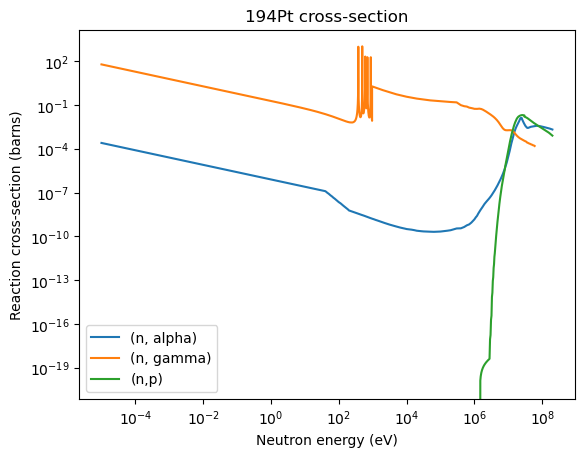

In [1539]:
#plt.figure(figsize=(10,6), dpi=200)

Pt194_CS_plot = (PtArrays[0][0], PtArrays[0][1], PtArrays[0][2])
legend = ('(n, alpha)', '(n, gamma)', '(n,p)')
for i in range(len(Pt194_CS_plot)):
    plt.plot(Pt194_CS_plot[i][:,0], Pt194_CS_plot[i][:,1]*1e24, label = legend[i])



plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.title("194Pt cross-section")
plt.xlabel('Neutron energy (eV)')
plt.ylabel('Reaction cross-section (barns)')

plt.show()

### ITER parameters

In [1540]:
first_wall_area = 6e6 #in cm^2
thickness1 = 1 #in cm
thickness2 = 1e-4 #in cm
fpy = 788400 #9.125 days in seconds, a full power year
fpy_full = fpy*20 #in seconds

### Transmutation reaction rate

To calculate the transmutation reaction rate one needs to know the number of nuclei per cm^3, the neutron flux and cross-section of the transmutation reaction, so that:

$R[cm^{-3} s^{-1}] = N[cm^{-3}] \times \sigma[cm^2] \times \Phi[cm^{-2} s^{-1}]$

And if one accounts for the thickness $\delta$, surface area of the first wall $A_{FW}$ and full power year $t_{fpy}$. 

$N_R = N[cm^{-3}] \times \sigma[cm^2] \times \Phi[cm^{-2} s^{-1}] \times A_{FW}[cm^2] \times \delta[cm] \times t_{fpy}[s]$

With this, multiplying by the total volume of the first wall layer, whether that'd be a coating or bulk, we obtain the number of reactions per second. Then, multiplying by the fpy in seconds, one can calculate the number of transmutation reactions per full power year. Assuming a wall made of 100% of the material of study, we can compare the number of new transmutated atoms with the number of original atoms and compare how many of the original atoms transmutated. There are two transmutation reaction values, the first being associated with total transmutation rate, including isotopes, the second and more important is the number of new atoms.

Some important concepts that this code misses are:

- No transportation code, assumes a constant flux at the wall based on the DT campaign at full power.
- Assumes constant thickness of the wall throught its surface area.
- Each neutron that penetrates the wall has always the same probability, the sum of each probabilty of each reaction along the thickness.
- There's no dynamic calculations, this is, accounting for the new nuclei as they are formed.

These first three parameters can overstimate the number of reactions. In general, the probability of the reaction (cross-section) is quite low, but multiplied by the high flux, it reaches significant values. The same neutron can only have one reaction (of the ones considered, since scattering is not included). Therefore, generally, this code overestimates the total transmutation rate that includes isotopes but is quite good for the estimation of the transmutation rate that changes the atomic number. The last parameter is harder to account for.

# Rhodium

# Platinum

## Differential equation approach

One can calculate the rate the number of produced is

$\dfrac{dN_i(t)}{dt} = -(\lambda_i + \sigma_i \Phi)N_i(t) + \sum_j (\lambda_{ij} + \sigma_{ij} \Phi)N_i(t)$

$N_i(t)$ - Number of nuclei at time $t$

$\lambda_i$ - Decay rate of nuclide i.

$\sigma_i$ - Total cross-section of nuclear reaction for nuclide i.

$\lambda_{ij}$ - Decay rate from nuclide j to  i.

$\sigma_{ij}$ - Cross-section of nuclear reaction from nuclide j to i.

$\lambda = \dfrac{ln2}{t_{1/2}}$


In [1541]:
# Define the differential equation system with energy dependence
def system_of_equations(N, t, lambdas, sigma_interp, lambdaij, sigmaij_interp, Phi_interp, nuclei_names):
    dNdt = np.zeros_like(N)
    num_nuclei = len(N)
    
    energy = Phi_interp.x  # Assume Phi_interp is an interpolation function for flux

    for i in range(num_nuclei):
        decay_term = - (lambdas[i] + np.sum(sigma_interp[i](energy) * Phi_interp(energy))) * N[i]
        production_term = 0
        
        for j in range(num_nuclei):
            sigma_ij_interp_func = sigmaij_interp[i][j]
                    
            # Check if the interpolation function is not zero
            if not np.all(sigma_ij_interp_func(energy) == 0):
                production_term += (lambdaij[i][j] + np.sum(sigma_ij_interp_func(energy) * Phi_interp(energy))) * N[j]
                #print(np.sum(sigma_ij_interp_func(energy) * Phi_interp(energy)))
            else:
                production_term += lambdaij[i][j]*N[j]
        
        
        #print("Decay term of {}:".format(nuclei_names[i]),decay_term)
        #print("Production term of {}:".format(nuclei_names[i]),production_term)
        #print()
        dNdt[i] = decay_term + production_term

    return dNdt

def decay_rate_function(half_life):
    #half-life in seconds
    return np.log(2)/half_life

In [1542]:
nuclei_names = ('Pt194', 'Pt195', 'Pt196', 'Pt197', 'Pt198', 'Pt199', 'Au197', 'Au199')

N_target_Pt194 = Pt194_abundance*(rho_Pt * N_A)/Pt194_A
N_target_Pt195 = Pt195_abundance*(rho_Pt * N_A)/Pt195_A
N_target_Pt196 = Pt196_abundance*(rho_Pt * N_A)/Pt196_A
N_target_Pt197 = 0
N_target_Pt198 = Pt198_abundance*(rho_Pt * N_A)/Pt198_A
N_target_Pt199 = 0
N_target_Au197 = 0
N_target_Au199 = 0

decay_Pt197 = decay_rate_function(71609)
decay_Pt199 = decay_rate_function(1848)

In [1543]:
#Only cross-section values
Pt194_n_gamma = PtArrays[0][1]
Pt195_n_gamma = PtArrays[1][1]
Pt196_n_gamma = PtArrays[2][1]
Pt197_n_gamma = PtArrays[3][0]
Pt198_n_gamma = PtArrays[4][1]

In [1544]:
# Set initial conditions and parameters
initial_conditions = np.array([N_target_Pt194, N_target_Pt195, N_target_Pt196, N_target_Pt197, 
                      N_target_Pt198, N_target_Pt199, N_target_Au197, N_target_Au199]) #number of nuclei in the start



lambdas = [0, 0, 0, decay_Pt197,0, decay_Pt199, 0, 0]

# Set up interpolation functions for cross-sections and flux
#These are the decay terms, responsible for the decrease of the isotopes either through decay or by neutron capture
energy_values_decay = [Pt194_n_gamma[:,0], Pt195_n_gamma[:,0], Pt196_n_gamma[:,0], Pt197_n_gamma[:,0], Pt198_n_gamma[:,0], np.zeros(5), np.zeros(5), np.zeros(5)] # Energy values given by the flux interpolation function
sigma_values_decay = [Pt194_n_gamma[:,1], Pt195_n_gamma[:,1], Pt196_n_gamma[:,1], Pt197_n_gamma[:,1], Pt198_n_gamma[:,1], np.zeros(5), np.zeros(5), np.zeros(5)]  # Specify your cross-section values
sigma_interp = [interp1d(energy, sigma, kind='linear', fill_value= 0.0, bounds_error=False) for energy, sigma in zip(energy_values_decay, sigma_values_decay)]


In [1545]:
#THESE ARE THE PRODUCTION TERMS

#falta preencher os valores, isto não está bem!
decay_chain = [
    [0, 0, 0, 0, 0, 0, 0, 0],  #Pt194
    [1, 0, 0, 0, 0, 0, 0, 0],  #Pt195
    [0, 1, 0, 0, 0, 0, 0, 0],  #Pt196
    [0, 0, 1, 0, 0, 0, 0, 0],  #Pt197
    [0, 0, 0, 1, 0, 0, 0, 0],  #Pt198
    [0, 0, 0, 0, 1, 0, 0, 0],  #Pt199
    [0, 0, 0, 0, 0, 0, 0, 0],  #Au197
    [0, 0, 0, 0, 0, 0, 0, 0]   #Au199
    ] #this has the true or false statements for if nuclide i is produced by j

sigmaij_interp = [
    [0, 0, 0, 0, 0, 0, 0, 0],  #Pt194
    [0, 0, 0, 0, 0, 0, 0, 0],  #Pt195
    [0, 0, 0, 0, 0, 0, 0, 0],  #Pt196
    [0, 0, 0, 0, 0, 0, 0, 0],  #Pt197
    [0, 0, 0, 0, 0, 0, 0, 0],  #Pt198
    [0, 0, 0, 0, 0, 0, 0, 0],  #Pt199
    [0, 0, 0, 0, 0, 0, 0, 0],  #Au197
    [0, 0, 0, 0, 0, 0, 0, 0]   #Au199
    ]

lambdaij = [
    [0, 0, 0, 0, 0, 0, 0, 0],  # N_target_Pt194
    [0, 0, 0, 0, 0, 0, 0, 0],  # N_target_Pt195
    [0, 0, 0, 0, 0, 0, 0, 0],  # N_target_Pt196
    [0, 0, 0, 0, 0, 0, 0, 0],  # N_target_Pt197
    [0, 0, 0, 0, 0, 0, 0, 0],  # N_target_Pt198
    [0, 0, 0, 0, 0, 0, 0, 0],  # N_target_Pt199
    [0, 0, 0, decay_Pt197, 0, 0, 0, 0],   # N_target_Au197
    [0, 0, 0, 0, 0, decay_Pt199, 0, 0]   # N_target_Au199
    ]


energy_range = np.linspace(0, 1e10, 10)
zero_values = np.zeros_like(energy_range)
zero_interp_function = interp1d(energy_range, zero_values, kind='linear', fill_value= 0.0, bounds_error=False)

energy_values_production = [Pt194_n_gamma[:,0], Pt195_n_gamma[:,0], Pt196_n_gamma[:,0], Pt197_n_gamma[:,0], Pt198_n_gamma[:,0], Pt198_n_gamma[:,0], np.zeros(5), np.zeros(5)]
sigma_values_production = [Pt194_n_gamma[:,1], Pt195_n_gamma[:,1], Pt196_n_gamma[:,1], Pt197_n_gamma[:,1], Pt198_n_gamma[:,1], Pt198_n_gamma[:,1], np.zeros(5), np.zeros(5)]  

for i in range(len(decay_chain)):
    for j in range(len(decay_chain)):
        if decay_chain[i][j] == 0:
            sigmaij_interp[i][j] = zero_interp_function
        else:
            energy = energy_values_production[i]
            sigma = sigma_values_production[i]
            sigmaij_interp[i][j] = interp1d(energy, sigma, kind='linear', fill_value= 0.0, bounds_error=False)

In [1546]:
# Set the time points at which you want to solve the equations
t1 = np.linspace(0, fpy, 10)
t2 = np.linspace(0, fpy_full, 10)
# Solve the differential equations
solution_fpy = odeint(system_of_equations, initial_conditions, t1, args=(lambdas, sigma_interp, lambdaij, sigmaij_interp, neutron_flux_function, nuclei_names))
solution_fpy_full = odeint(system_of_equations, initial_conditions, t2, args=(lambdas, sigma_interp, lambdaij, sigmaij_interp, neutron_flux_function, nuclei_names))

In [1547]:
init_solution_fpy = np.array(solution_fpy[0])
final_solution_fpy = np.array(solution_fpy[-1])

init_solution_fpy_full = np.array(solution_fpy_full[0])
final_solution_fpy_full = np.array(solution_fpy_full[-1])

In [1548]:
total_nuclei = np.sum(final_solution_fpy)
change = final_solution_fpy*100/total_nuclei
variation_fpy = (final_solution_fpy-initial_conditions)*100/final_solution_fpy
for name,change,variation in zip(nuclei_names, change, variation_fpy):
    if variation > 0:
        print('{} increased {v:.6f}% to a value of {c:.6f}%'.format(name, v=variation, c=change))
    else:
        print('{} decreased {v:.6f}% to a value of {c:.6f}%'.format(name,v=variation, c=change))

Pt194 decreased -0.002230% to a value of 33.314740%
Pt195 decreased -0.000391% to a value of 34.072071%
Pt196 increased 0.000654% to a value of 25.298456%
Pt197 increased 100.000000% to a value of 0.000444%
Pt198 decreased -0.016777% to a value of 7.310116%
Pt199 increased 100.000000% to a value of 0.000004%
Au197 increased 100.000000% to a value of 0.002946%
Au199 increased 100.000000% to a value of 0.001222%


In [1549]:
total_nuclei = np.sum(final_solution_fpy_full)
change = final_solution_fpy_full*100/total_nuclei
variation_fpy_full = (final_solution_fpy_full-initial_conditions)*100/final_solution_fpy_full


for name,change,variation in zip(nuclei_names, change, variation_fpy_full):
    if variation > 0:
        print('{} increased {v:.6f}% to a value of {c:.6f}%'.format(name, v=variation, c=change))
    else:
        print('{} decreased {v:.6f}% to a value of {c:.6f}%'.format(name,v=variation, c=change))

Pt194 decreased -0.044611% to a value of 33.283686%
Pt195 decreased -0.007886% to a value of 34.052186%
Pt196 increased 0.013079% to a value of 25.288728%
Pt197 increased 100.000000% to a value of 0.000444%
Pt198 decreased -0.336082% to a value of 7.283145%
Pt199 increased 100.000000% to a value of 0.000004%
Au197 increased 100.000000% to a value of 0.067332%
Au199 increased 100.000000% to a value of 0.024475%


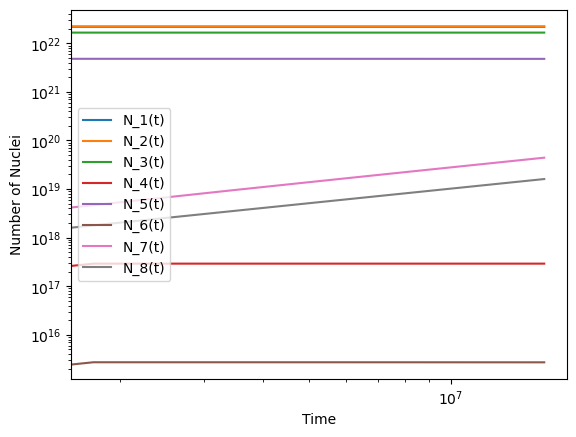

In [1550]:
# Plot the results
for i in range(len(initial_conditions)):
    plt.plot(t, solution[:, i], label=f'N_{i+1}(t)')

plt.xlabel('Time')
plt.ylabel('Number of Nuclei')
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.show()